## Homework2
### Yichi Zhang
### UNI:yz3716

# Task2

# 2.1 Determine which features are continuous vs categorical. Drop rows without a valid sales price.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import copy
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [2]:
#Task2


#2.1

df2 = pd.read_csv('../Desktop/housedata/data.csv')
df2 = df2[df2['price'] != 0]



Since the price equal to zero is complete impossible in this dataset, so we dropped all row with price equal to zero

# 2.2 Visualize the univariate distribution of each continuous feature, and the distribution of the target. Do you notice anything? Is there something that might require special treatment?

In [3]:
#2.2


drop = ['date','street','country']

df2 = df2.drop(columns=drop)



In [4]:
continuous2 = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
               'sqft_above', 'sqft_basement','yr_built', 'yr_renovated']
catagorical = ['waterfront','view','condition']

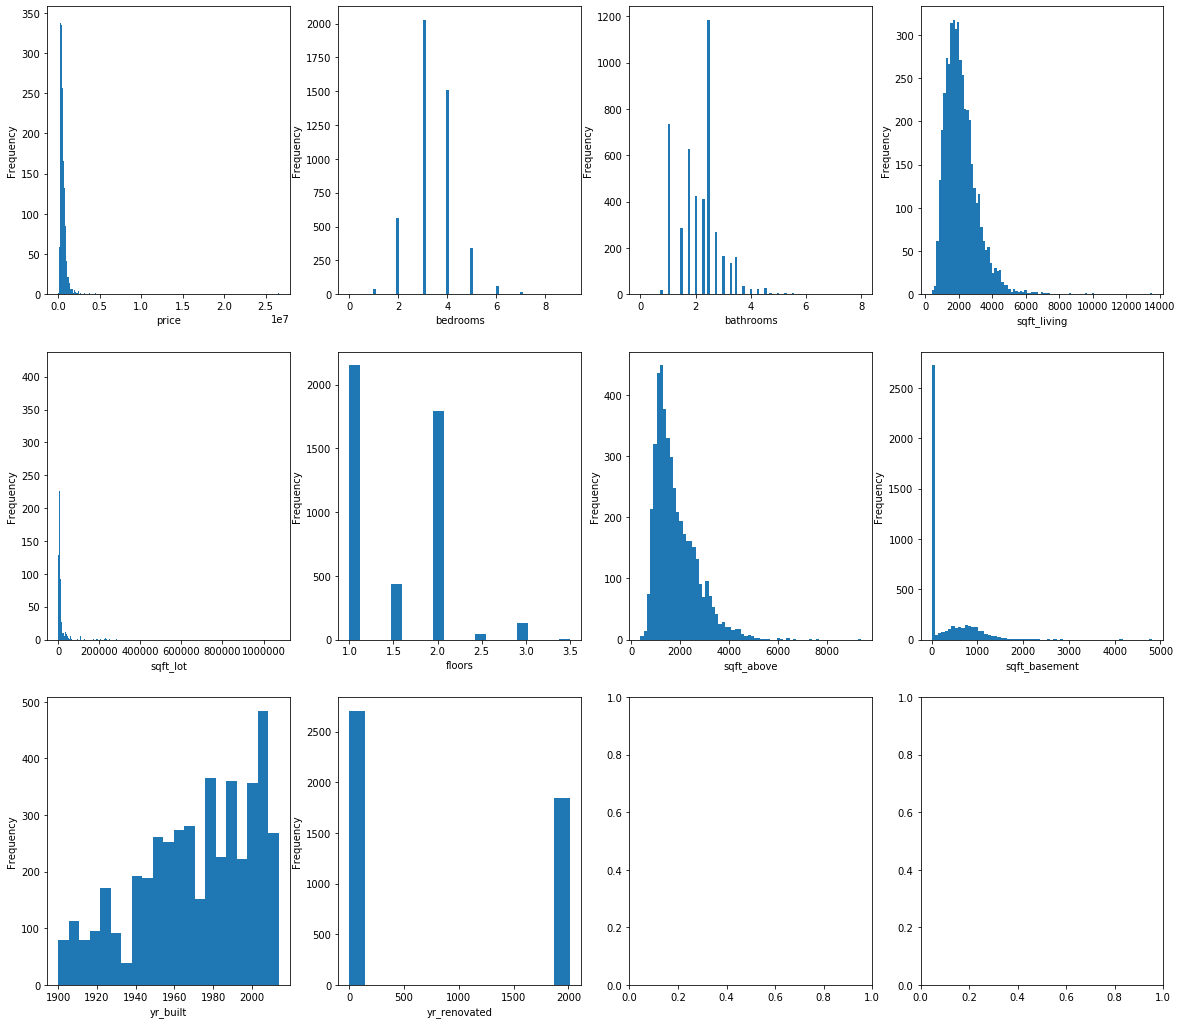

In [5]:
fig2,ax2 = plt.subplots(3,4, figsize=(20,18))

for i in range(len(continuous2)):
    j = i//4
    ax2[j,(i%4)].hist(df2[continuous2[i]],bins = "auto")
    ax2[j,(i%4)].set_xlabel(continuous2[i])
    ax2[j,(i%4)].set_ylabel('Frequency')
    


plt.show()

According to th graph above, we find for most of continuous varibale, there are some extremely high value. However, not all high value need special treatment. I found only 3 outlier here. The first house with price 26590000 but it's sqft_living is only 1180 which is too small compare with the other house which is cheaper than the house. The Second house have price 12899000 which only have 2190 sqft_living(also too small). The third house is a house with 1074218 sqft_lot but only 542500 dollar which is too cheap. So this three outliers require special treatment before the analysis.

# 2.3 Visualize the dependency of the target on each continuous feature (2d scatter plot).

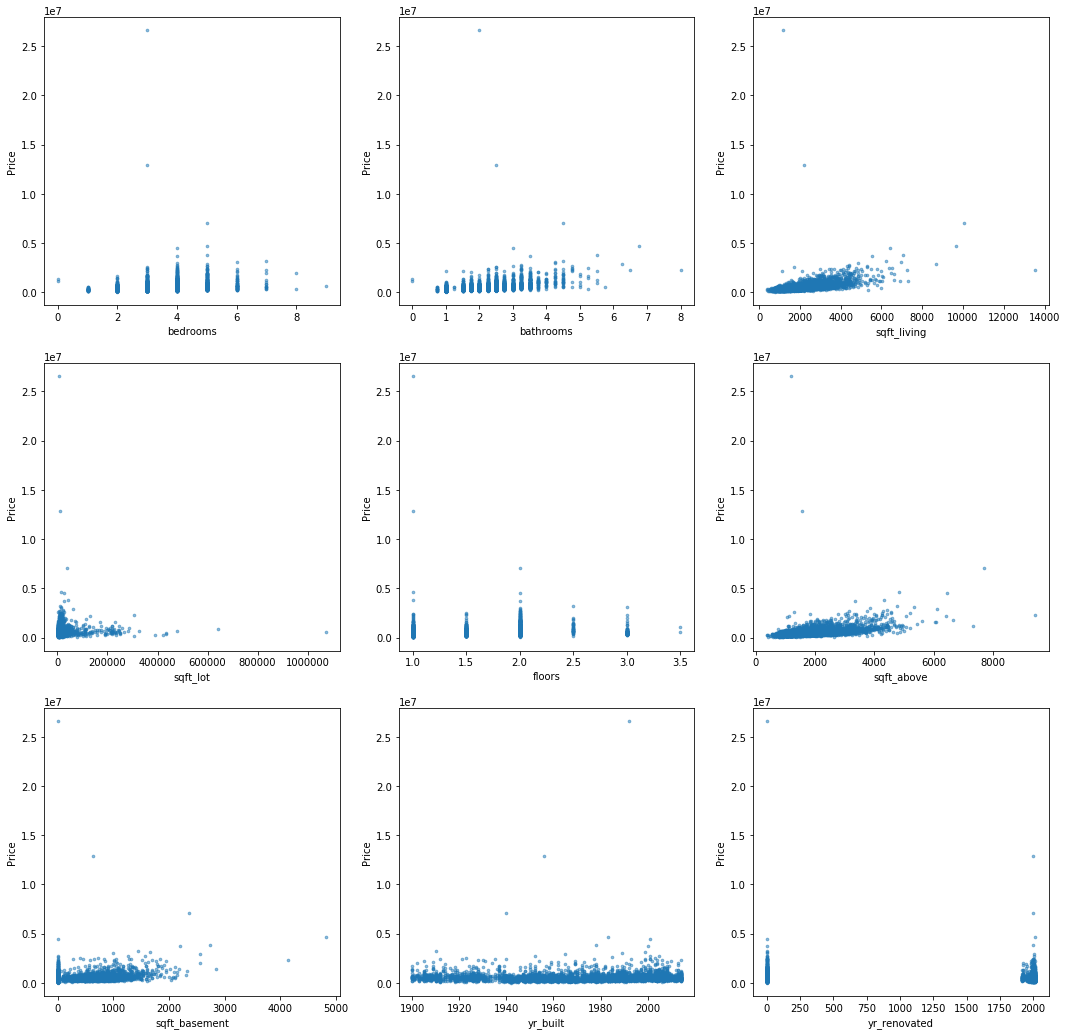

In [6]:
#2.3


fig3,ax3 = plt.subplots(3,3, figsize=(18,18))

for i in range(1,len(continuous2)):
    j = (i-1)//3
    ax3[j,((i-1)%3)].scatter(df2[continuous2[i]],df2['price'],alpha = 0.5, s = 7)
    ax3[j,((i-1)%3)].set_xlabel(continuous2[i])
    ax3[j,((i-1)%3)].set_ylabel('Price')
plt.show()

# 2.4 Split data in training and test set. Do not use the test-set unless for a final evaluation in 2.5. Use ColumnTransformer and pipeline to encode categorical variables (your choice of OneHotEncoder or another one from the categorical_encoder package, or both). Impute missing values using SimpleImputer. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. Does scaling the data (within the pipeline) with StandardScaler help? Use the preprocessing that works best going forward.

In [7]:
from sklearn.impute import SimpleImputer


continuous2 = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
               'sqft_above', 'sqft_basement','yr_built']

#,'yr_renovated'

In [8]:
df2['yr_renovated'] = df2['yr_renovated'].replace(0, np.nan)
y2 = df2['price']
X2 = df2.loc[:, df2.columns != 'price']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)



In [9]:
#Pipeline for Linear Regression with StandardScalar
ImputeAndStandrad = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median')
                                  ,StandardScaler())


preprocess3 = make_column_transformer(
    (ImputeAndStandrad,['yr_renovated']),
    (StandardScaler(),continuous2),
    (OneHotEncoder(), catagorical),
    remainder = 'passthrough')


Pipe = make_pipeline(TargetEncoder(cols=['city','statezip']),
                     preprocess3,LinearRegression())

scores2LR = cross_val_score(Pipe,X2_train, y2_train, cv=10)

np.mean(scores2LR)

0.6062967887093189

In [10]:
#Pipeline for Linear Regression with StandardScalar

Unpreprocess2 = make_column_transformer(
    (ImputeAndStandrad,['yr_renovated']),
    (OneHotEncoder(), catagorical),
    remainder = 'passthrough')


UnPipe = make_pipeline(TargetEncoder(cols=['city','statezip']),
                     Unpreprocess2,SimpleImputer(missing_values=np.nan, strategy='median'),LinearRegression())

Unscores2LR = cross_val_score(UnPipe,X2_train, y2_train, cv=10)

np.mean(Unscores2LR)




0.6062967887097677

In [11]:
#Use pipeline with StandardScaler(Four Models)


from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline


param_gridTotal = {'regressor': [LinearRegression(),Ridge(), Lasso(),ElasticNet()]}

PipeTotal = Pipeline([('scaler',TargetEncoder(cols=['city','statezip'])),
                           ('transform',preprocess3),
                           ('regressor',LinearRegression())])

#('imputer',SimpleImputer(missing_values=np.nan, strategy='median')),


gridTotal = GridSearchCV(PipeTotal,param_gridTotal)

gridTotal.fit(X2_train, y2_train)


Model = ['LinearRegression','Ridge', 'Lasso','ElasticNet']
for i in range(4):
    print(Model[i] + ': '+ str(gridTotal.cv_results_['mean_test_score'][i]))
                          

LinearRegression: 0.5253379119557631
Ridge: 0.5256190672509392
Lasso: 0.5253388004658731
ElasticNet: 0.4915941434860966


In [12]:
#Use pipeline without StandardScaler(Four Models)


param_gridTotal = {'regressor': [LinearRegression(),Ridge(), Lasso(),ElasticNet()]}

UnPipeTotal = Pipeline([('scaler',TargetEncoder(cols=['city','statezip'])),
                           ('transform',Unpreprocess2),
                           ('regressor',LinearRegression())])

#('imputer',SimpleImputer(missing_values=np.nan, strategy='median')),


UngridTotal = GridSearchCV(PipeTotal,param_gridTotal)

UngridTotal.fit(X2_train, y2_train)

for i in range(4):
    print(Model[i] + ': '+ str(UngridTotal.cv_results_['mean_test_score'][i]))

LinearRegression: 0.5253379119557631
Ridge: 0.5256190672509392
Lasso: 0.5253388004658731
ElasticNet: 0.4915941434860966


According to the output above, we can see that, the performance of four model doesn't change a lot if we don't add the standardScaler. I run my program several times but the score doesn't change. So I can conclude that toe the four intial model, StandardScaler doesn't affect the performance of the models. 

# 2.5 Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

{'ridge__alpha': 27.825594022071257}
0.725319123720726


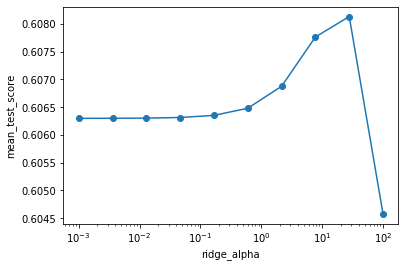

In [13]:
#Ridge tuning parameter


PipeRidge = make_pipeline(TargetEncoder(cols=['city','statezip']),
                     preprocess3,Ridge())

#,SimpleImputer(missing_values=np.nan, strategy='median')


PipeRidge = GridSearchCV(PipeRidge,
            param_grid={'ridge__alpha': np.logspace(-3, 2, 10)},
            cv=10)


PipeRidge.fit(X2_train,y2_train)

print(PipeRidge.best_params_)
print(PipeRidge.score(X2_test, y2_test))


fig4,ax4 = plt.subplots()

ax4.plot(np.logspace(-3, 2,10),PipeRidge.cv_results_['mean_test_score'],marker='o')
ax4.set_xscale('log')
ax4.set_xlabel('ridge_alpha')
ax4.set_ylabel('mean_test_score')




plt.show()


{'lasso__alpha': 297.6351441631313}
0.7286925111213995


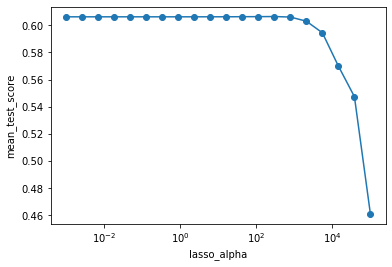

In [14]:
#Lasso Tuning Parameter


PipeLasso = make_pipeline(TargetEncoder(cols=['city','statezip']),
                     preprocess3,Lasso())


#,SimpleImputer(missing_values=np.nan, strategy='median')

PipeLasso = GridSearchCV(PipeLasso,
            param_grid={'lasso__alpha': np.logspace(-3, 5, 20)},
            cv=10)


PipeLasso.fit(X2_train,y2_train)

print(PipeLasso.best_params_)
print(PipeLasso.score(X2_test, y2_test))


fig5,ax5 = plt.subplots()

ax5.plot(np.logspace(-3, 5, 20),PipeLasso.cv_results_['mean_test_score'],marker='o')
ax5.set_xscale('log')
ax5.set_xlabel('lasso_alpha')
ax5.set_ylabel('mean_test_score')



plt.show()

In [15]:
#Elastic Tuning Parameter


PipeElast = make_pipeline(TargetEncoder(cols=['city','statezip']),
                     preprocess3,ElasticNet())


#,SimpleImputer(missing_values=np.nan, strategy='median')

PipeElast = GridSearchCV(PipeElast,
            param_grid={'elasticnet__alpha': np.logspace(-4, -1, 10),
              'elasticnet__l1_ratio': [0.01, .1, .5, .8, .9, .95, .98, 1]},
            cv=5)


PipeElast.fit(X2_train,y2_train)

print(PipeElast.best_params_)
print(PipeElast.score(X2_test, y2_test))





{'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.1}
0.7248332086809632


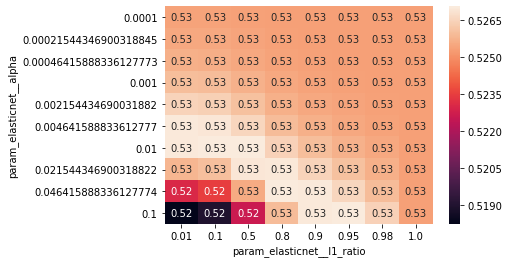

In [16]:
import seaborn as sns
res = pd.pivot_table(pd.DataFrame(PipeElast.cv_results_),
values = 'mean_test_score',index = 'param_elasticnet__alpha',columns = 'param_elasticnet__l1_ratio')


sns.heatmap(res,annot = True)

According to the output above, we can see that, after we tuning the hyperparameter, the socre of our model increase from the 50 percent to almost 70 percent.

# 2.6 Visualize the 20 most important coefficients of the resulting models. Do they agree on which features are important?

In [17]:
#2.6

X_temp2 = preprocess3.fit_transform(X2_train)

CataName = PipeRidge.best_estimator_.named_steps['columntransformer'].transformers_[2][1].get_feature_names().tolist()

#catagorical = ['waterfront','view','condition']
#continuous2 = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement','yr_built']


CategoricalFeature = []

for i in range(len(CataName)):
    temp = int(CataName[i][1])
    CategoricalFeature.append(catagorical[temp]+CataName[i][3])

CoeffNameRig = ['yr_renovated'] + continuous2 + CategoricalFeature + ['city','statezip']


CoeffNumberRig = PipeRidge.best_estimator_.named_steps['ridge'].coef_.tolist()
CoeffNumberLas = PipeLasso.best_estimator_.named_steps['lasso'].coef_.tolist()
CoeffNumberElas = PipeElast.best_estimator_.named_steps['elasticnet'].coef_.tolist()

coefficientsRidge = list(zip(CoeffNameRig,CoeffNumberRig))
coefficientsLas = list(zip(CoeffNameRig,CoeffNumberLas))
coefficientsElas = list(zip(CoeffNameRig,CoeffNumberElas))

VisCoeffRidge = sorted(coefficientsRidge, key = lambda x: abs(x[1]),reverse=True)
VisCoeffLas = sorted(coefficientsLas, key = lambda x: abs(x[1]),reverse=True)
VisCoeffElas = sorted(coefficientsElas, key = lambda x: abs(x[1]),reverse=True)



FeaturesRidge = []
CoeffRidge = []


FeaturesLas = []
CoeffLas = []


FeaturesElas = []
CoeffElas = []

for i in range(20):
    FeaturesRidge.append(VisCoeffRidge[i][0])
    CoeffRidge.append(VisCoeffRidge[i][1])
    FeaturesLas.append(VisCoeffLas[i][0])
    CoeffLas.append(VisCoeffLas[i][1])
    FeaturesElas.append(VisCoeffElas[i][0])
    CoeffElas.append(VisCoeffElas[i][1])








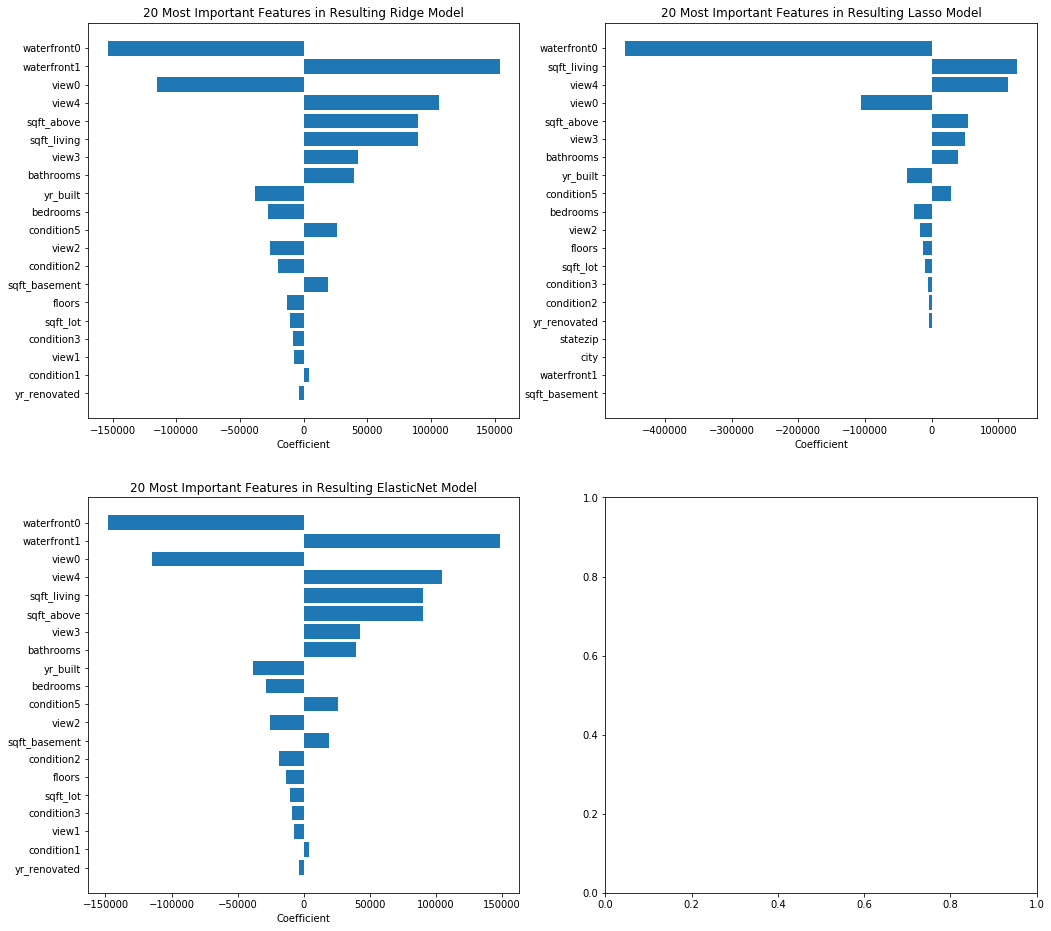

In [18]:
fig2,ax2 = plt.subplots(2,2, figsize=(17,16))

ax2[0,0].barh(FeaturesRidge,CoeffRidge)
ax2[0,0].invert_yaxis()
ax2[0,0].set_xlabel('Coefficient')
ax2[0,0].set_title('20 Most Important Features in Resulting Ridge Model')

ax2[0,1].barh(FeaturesLas,CoeffLas)
ax2[0,1].invert_yaxis()
ax2[0,1].set_xlabel('Coefficient')
ax2[0,1].set_title('20 Most Important Features in Resulting Lasso Model')

ax2[1,0].barh(FeaturesElas,CoeffElas)
ax2[1,0].invert_yaxis()
ax2[1,0].set_xlabel('Coefficient')
ax2[1,0].set_title('20 Most Important Features in Resulting ElasticNet Model')


plt.show()



According to the plot above, all three models almost agree on all features(Looking at there y axis). There are some feature like waterfront0, waterfront1,view0, view4, sqft_living etc have much higher coefficient in three plots. Therefore, those feature are very important for the prediction. However, there is another reason explained why almost all three model agree on same feature. Since we only have 23 feature in our dataset but we choose 20 most important feature. Therefore, there must be serious overlap between each models.